In [1]:
# installing all the necessary dependencies
import os, re
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    StackingRegressor
)
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error
import joblib

In [2]:
# ---------- 1) LOAD & BASIC CLEAN ----------
csv_path = "PRSA_data_2010.1.1-2014.12.31.csv" 
assert os.path.exists(csv_path), f"CSV file not found at {csv_path}"

df = pd.read_csv(csv_path)
print("Original columns:", list(df.columns)[:20])
print(df.shape)
df.head()

Original columns: ['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']
(43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
# Normalize column names to friendly lowercase identifiers
def clean_col(c):
    c = str(c).strip().lower()
    # unify pm2.5 -> pm25
    c = c.replace("pm2.5", "pm25")
    # replace non-alphanum with underscore
    c = re.sub(r'[^0-9a-z]+', '_', c)
    c = c.strip('_')
    return c

df.columns = [clean_col(c) for c in df.columns]
print("Normalized columns:", list(df.columns))

Normalized columns: ['no', 'year', 'month', 'day', 'hour', 'pm25', 'dewp', 'temp', 'pres', 'cbwd', 'iws', 'is', 'ir']


In [4]:
# ---------- 2) BUILD DATETIME ----------
# UCI has year, month, day, hour columns; construct a single datetime column
if set(['year', 'month', 'day', 'hour']).issubset(df.columns):
    df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])
    df = df.sort_values('datetime').reset_index(drop=True)
    df.set_index('datetime', inplace=False)
else:
    # If dataset already has a timestamp column - try 'time' or 'date' detection
    possible_ts = [c for c in df.columns if 'date' in c or 'time' in c or 'datetime' in c]
    if possible_ts:
        df['datetime'] = pd.to_datetime(df[possible_ts[0]])
    else:
        raise ValueError("Couldn't find (year,month,day,hour) nor timestamp column. Please add a datetime column.")

df = df.sort_values('datetime').reset_index(drop=True)
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

In [5]:
# ---------- 3) CYCLICAL ENCODING ----------
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)

In [6]:
# ---------- 4) RENAME / INTERPRET COLUMNS ----------
# Typical UCI fields: pm25, dewp, temp, pres, cbwd (wind direction categorical), iws (wind speed), is, ir
# Map common names:
col_map = {}
if 'pm25' in df.columns:
    col_map['pm25'] = 'pm25'
if 'dewp' in df.columns:
    col_map['dewp'] = 'dewpoint'
if 'temp' in df.columns:
    col_map['temp'] = 'temp'
if 'pres' in df.columns:
    col_map['pres'] = 'pressure'
if 'iws' in df.columns:
    col_map['iws'] = 'wind_speed'
if 'cbwd' in df.columns:
    col_map['cbwd'] = 'cbwd'   # categorical wind-dir
    
df = df.rename(columns=col_map)
print("After rename, sample columns:", list(df.columns))

After rename, sample columns: ['no', 'year', 'month', 'day', 'hour', 'pm25', 'dewpoint', 'temp', 'pressure', 'cbwd', 'wind_speed', 'is', 'ir', 'datetime', 'dayofweek', 'is_weekend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']


In [7]:
# ---------- 5) LAGS & ROLLING FEATURES ----------
# We'll create lag features from pm25 (past values only)
target_col = 'pm25'
lags = [1, 3, 6, 12, 24]   # hours
for lag in lags:
    df[f'pm25_lag_{lag}'] = df[target_col].shift(lag)

# rolling stats (use shifted series so we never use 'future' info)
df['pm25_roll_mean_6h'] = df[target_col].shift(1).rolling(window=6, min_periods=1).mean()
df['pm25_roll_std_6h']  = df[target_col].shift(1).rolling(window=6, min_periods=1).std().fillna(0)

# slope / trend over last 3 hours (simple linear slope)
def rolling_slope(series, window=3):
    # compute slope using polyfit (fast enough)
    arr = series.values
    out = np.full_like(arr, np.nan, dtype=float)
    for i in range(window-1, len(arr)):
        x = np.arange(window)
        y = arr[i-window+1:i+1]
        if np.any(np.isnan(y)):
            out[i] = np.nan
        else:
            out[i] = np.polyfit(x, y, 1)[0]
    return pd.Series(out, index=series.index)

df['pm25_slope_3h'] = rolling_slope(df[target_col].shift(1), window=3)

In [8]:
# ---------- 6) WIND FEATURES ----------
# UCI has cbwd categorical (NE, NW, SE, cv). We'll one-hot encode cbwd in the pipeline.
# Optional: map cbwd -> approximate u/v (only if you want numeric wind vector)
wind_map = {'NE':45, 'NW':315, 'SE':135, 'cv':np.nan}  # 'cv' often means "calm / variable"
if 'cbwd' in df.columns:
    df['cbwd'] = df['cbwd'].astype(str).replace('nan', np.nan)

# if numeric wind_speed exists (iws), we can optionally estimate u/v by mapping cbwd to angle
if 'wind_speed' in df.columns and 'cbwd' in df.columns:
    ang = df['cbwd'].map(wind_map)
    df['wind_u'] = df['wind_speed'] * np.cos(np.deg2rad(ang))
    df['wind_v'] = df['wind_speed'] * np.sin(np.deg2rad(ang))

In [9]:
# ---------- 7) TRAFFIC & NEIGHBORS ----------
# UCI does NOT include traffic_count or neighbor stations. If you have external traffic or other stations,
# join them on datetime BEFORE running the pipeline.
if 'traffic_count' not in df.columns:
    print("Note: no 'traffic_count' column found. Traffic-based features will be skipped unless you merge traffic data.")
else:
    df['traffic_roll3'] = df['traffic_count'].shift(1).rolling(3).mean()
    df['traffic_roll6'] = df['traffic_count'].shift(1).rolling(6).mean()

Note: no 'traffic_count' column found. Traffic-based features will be skipped unless you merge traffic data.


In [10]:
# ---------- 8) MISSING TARGET HANDLING ----------
# For supervised regression we need rows where current pm25 (target) is present.
initial_len = len(df)
df = df[~df[target_col].isna()].copy()   # drop rows where target is missing
print(f"Dropped {initial_len - len(df)} rows with missing target (pm25).")

# drop rows where any of the lag features are still NaN (start of series)
lag_cols = [f'pm25_lag_{l}' for l in lags] + ['pm25_roll_mean_6h','pm25_roll_std_6h','pm25_slope_3h']
df = df.dropna(subset=lag_cols, how='any').reset_index(drop=True)
print("After dropping lag-NaN rows:", df.shape)

Dropped 2067 rows with missing target (pm25).
After dropping lag-NaN rows: (39753, 30)


In [11]:
# ---------- 9) DEFINE FEATURE LISTS ----------
num_cols = []
for c in ['dewpoint','temp','pressure','wind_speed','wind_u','wind_v']:
    if c in df.columns:
        num_cols.append(c)

# add pm2.5 lags & rolling stats
num_cols += [c for c in lag_cols if c in df.columns]

# cyclical numeric encodings
num_cols += ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

cat_cols = []
for c in ['month','is_weekend','cbwd']:   # cbwd categorical wind-dir
    if c in df.columns:
        cat_cols.append(c)

print("Numeric features (example):", num_cols[:20])
print("Categorical features (example):", cat_cols)

Numeric features (example): ['dewpoint', 'temp', 'pressure', 'wind_speed', 'wind_u', 'wind_v', 'pm25_lag_1', 'pm25_lag_3', 'pm25_lag_6', 'pm25_lag_12', 'pm25_lag_24', 'pm25_roll_mean_6h', 'pm25_roll_std_6h', 'pm25_slope_3h', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
Categorical features (example): ['month', 'is_weekend', 'cbwd']


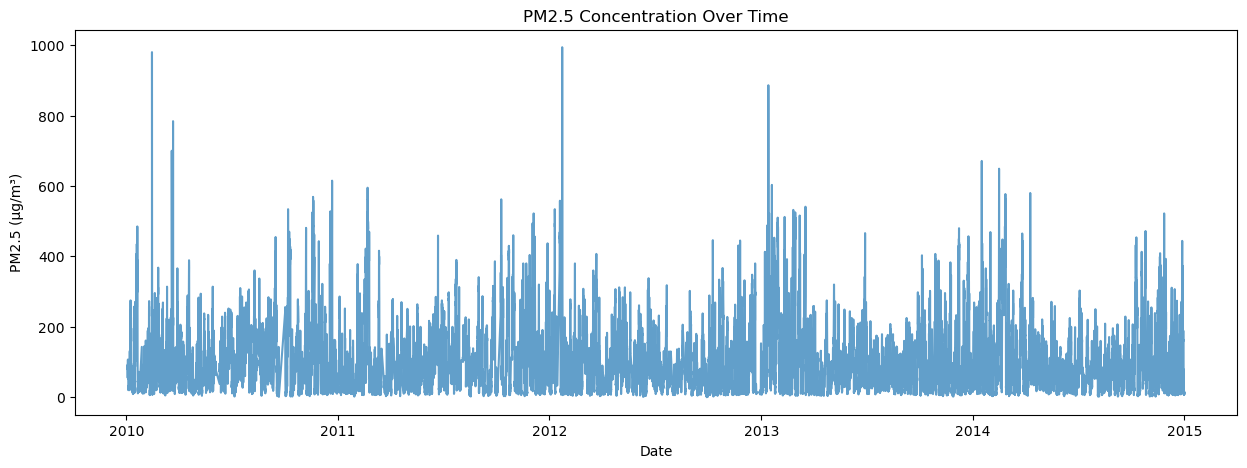

In [12]:
# PM2.5 over time
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df['datetime'], df['pm25'], alpha=0.7)
plt.title("PM2.5 Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.show()

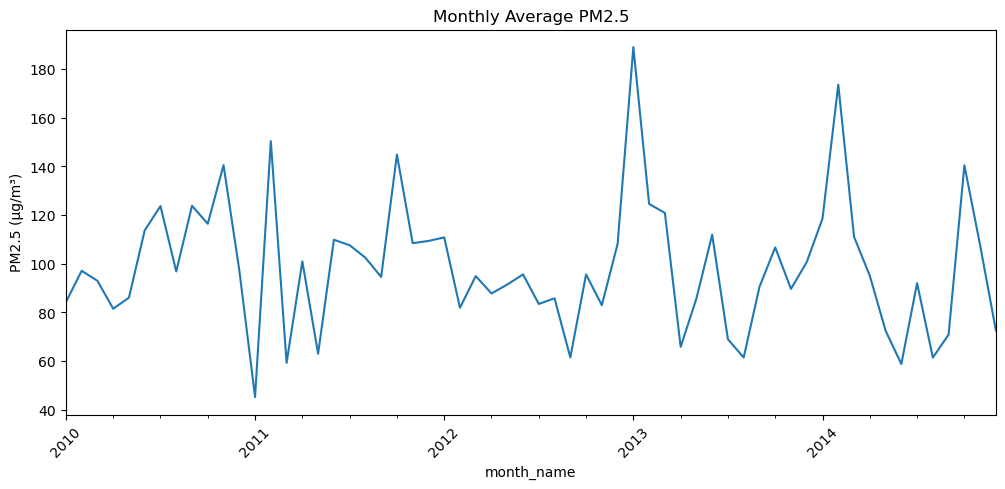

In [13]:
# Monthly average trend
df['month_name'] = df['datetime'].dt.to_period('M')
monthly_mean = df.groupby('month_name')['pm25'].mean()

plt.figure(figsize=(12,5))
monthly_mean.plot()
plt.title("Monthly Average PM2.5")
plt.ylabel("PM2.5 (µg/m³)")
plt.xticks(rotation=45)
plt.show()

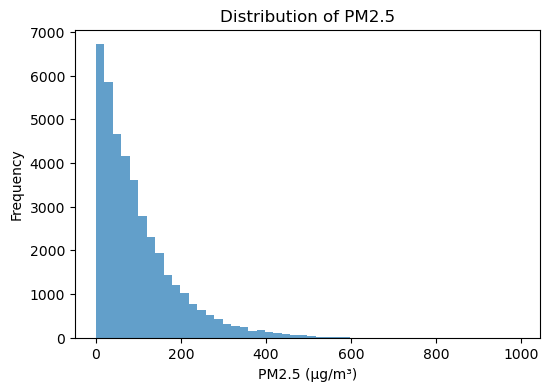

In [14]:
# Distribution of PM2.5
plt.figure(figsize=(6,4))
plt.hist(df['pm25'].dropna(), bins=50, alpha=0.7)
plt.title("Distribution of PM2.5")
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Frequency")
plt.show()

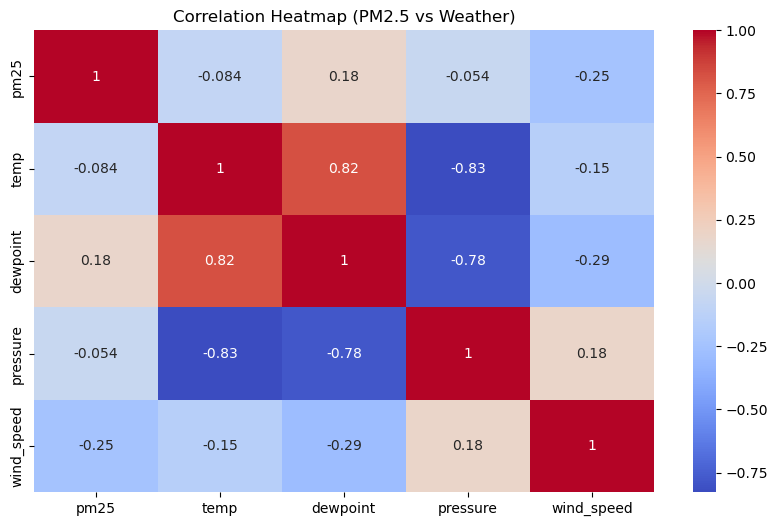

In [15]:
# Correlation heatmap
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df[['pm25','temp','dewpoint','pressure','wind_speed']].corr(),
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (PM2.5 vs Weather)")
plt.show()

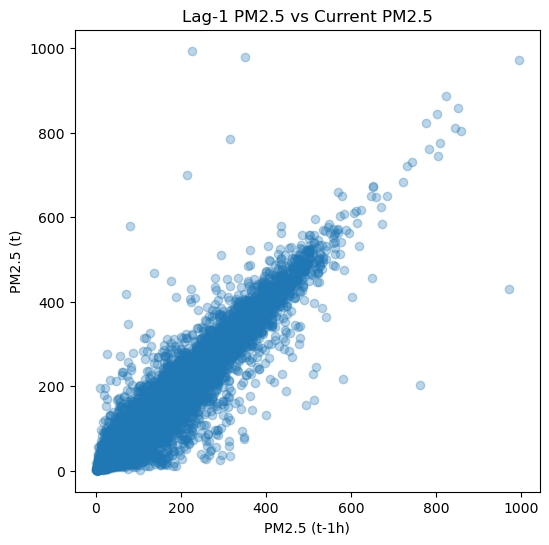

In [16]:
# Lag effect check (scatter of lag vs PM2.5)
plt.figure(figsize=(6,6))
plt.scatter(df['pm25_lag_1'], df['pm25'], alpha=0.3)
plt.title("Lag-1 PM2.5 vs Current PM2.5")
plt.xlabel("PM2.5 (t-1h)")
plt.ylabel("PM2.5 (t)")
plt.show()

In [17]:
# ---------- 10) PREPROCESSOR (sklearn pipeline) ----------
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', RobustScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full'))   # optional -- keeps 95% variance
])

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
], remainder='drop', verbose_feature_names_out=False)